In [1]:
import tensorflow as tf


In [2]:
print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0


2022-12-09 05:52:51.420407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 05:52:51.514837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 05:52:51.515663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
dataset_path = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/'



In [4]:
Efficientnet_b0 = 'https://tfhub.dev/google/efficientnet/b0/classification/1'


In [5]:
import os
import tensorflow_hub as hub
import tensorflow as tf
import pathlib
import cv2
from sklearn.utils import shuffle
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [6]:
train_data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2)

test_data_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2)

In [7]:
# GPU setup
batch_size = 32
img_height = 224
img_width = 224
train_data = train_data_generator.flow_from_directory(
    dataset_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = test_data_generator.flow_from_directory(
    dataset_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


## Efficientnet_b0

In [8]:
#model_Efficientnet.trainable = False

In [9]:
def plot_history(history, metric, val_metric):
  acc = history.history[metric]
  val_acc = history.history[val_metric]

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(len(acc))

  fig=plt.figure(figsize=(12, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylim([min(plt.ylim()),1])
  plt.grid(True)
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.grid(True)
  plt.title('Training and Validation Loss')
  plt.show()
  fig.savefig('traininghistory.pdf')



In [13]:
from tensorflow.keras.models import load_model

In [14]:
# model_Efficientnet = load_model('/content/gdrive/MyDrive/CMPE255_ASL_PROJECT/Efficientnet_model.h5', custom_objects={'KerasLayer':hub.KerasLayer})

In [15]:
# efficientnet_model = model_Efficientnet.fit(train_data, epochs = 1, verbose = 1, validation_data=val_data)


## Inception ResNet V2

In [16]:
from keras.callbacks import EarlyStopping

In [17]:
inceptionResNetV2 = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5'

--2022-12-09 05:54:05--  http://google.com/
Resolving google.com (google.com)... ^C


In [19]:
model_inceptionResNetV2 = tf.keras.Sequential([
    hub.KerasLayer('/kaggle/input/resmodel', input_shape = (224,224,3),
               trainable=False, arguments=dict(batch_norm_momentum=0.997)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(29, activation = 'softmax')
])



2022-12-09 05:54:09.149078: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 05:54:09.149636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 05:54:09.150510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 05:54:09.151261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [20]:
model_inceptionResNetV2.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [21]:
model_inceptionResNetV2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              55875273  
_________________________________________________________________
flatten (Flatten)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               100200    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                2929      
Total params: 55,978,402
Trainable params: 103,129
Non-trainable params: 55,875,273
_________________________________________________________________


In [22]:
tf.config.experimental_run_functions_eagerly(True)

In [23]:
inceptionResNetV2_model = model_inceptionResNetV2.fit(train_data, epochs = 10, verbose = 1, validation_data=val_data)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
2022-12-09 05:54:21.009527: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-09 05:54:32.911785: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2175/2175 [==============================] - 1475s 668ms/step - loss: 1.2254 - accuracy: 0.6580 - val_loss: 1.1934 - val_accuracy: 0.6450
Epoch 2/10
2175/2175 [==============================] - 1340s 616ms/step - loss: 0.7690 - accuracy: 0.7649 - val_loss: 1.2638 - val_accuracy: 0.6621
Epoch 3/10
2175/2175 [==============================] - 1331s 612ms/step - loss: 0.6966 - accuracy: 0.7861 - val_loss: 1.0410 - val_accuracy: 0.6994
Epoch 4/10
2175/2175 [==============================] - 1312s 603ms/step - loss: 0.6497 - accuracy: 0.8014 - val_loss: 1.1430 - val_accuracy: 0.7094
Epoch 5/10
2175/2175 [==============================] - 1314s 604ms/step - loss: 0.6181 - accuracy: 0.8118 - val_loss: 1.0717 - val_accuracy: 0.7142
Epoch 6/10
2175/2175 [==============================] - 1310s 602ms/step - loss: 0.5999 - accuracy: 0.8163 - val_loss: 1.1591 - val_accuracy: 0.6752
Epoch 7/10
2175/2175 [==============================] - 1303s 599ms/step - loss: 0.5807 - accuracy: 0.8216 - val_loss

In [24]:
model_inceptionResNetV2.save('/kaggle/working/model_inceptionResNetV2.h5')

In [25]:
!cd /kaggle/working

In [26]:
!zip -r file.zip /kaggle/working/model_inceptionResNetV2.h5

  adding: kaggle/working/model_inceptionResNetV2.h5 (deflated 7%)


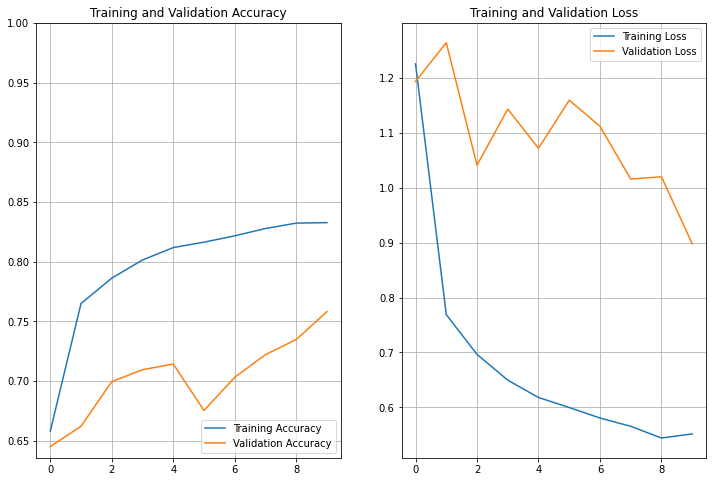

In [27]:
plot_history(inceptionResNetV2_model, 'accuracy', 'val_accuracy')